In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import defaultdict

In [2]:
df = pd.read_csv("Real_Data.csv")
df

,Date,A1,A2,B1,B2,A_Score,B_Score
0,11-07-2025,NL,HS,KG,DS,21,16
1,11-07-2025,IG,KS,NL,HS,21,17
2,11-07-2025,IG,KS,KG,DS,21,10
3,11-07-2025,NL,HS,KG,DS,21,19
4,11-07-2025,NL,HS,IG,KS,21,19
...,...,...,...,...,...,...,...
206,09-09-2025,KS,NL,DS,MC,21,15
207,11-09-2025,NL,MC,DS,HS,21,18
208,11-09-2025,KG,KS,DS,HS,21,17
209,11-09-2025,DS,HS,NL,MC,21,16


In [3]:
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")
# df = df.sort_values("Date").reset_index(drop=True)
df

,Date,A1,A2,B1,B2,A_Score,B_Score
0,2025-07-11,NL,HS,KG,DS,21,16
1,2025-07-11,IG,KS,NL,HS,21,17
2,2025-07-11,IG,KS,KG,DS,21,10
3,2025-07-11,NL,HS,KG,DS,21,19
4,2025-07-11,NL,HS,IG,KS,21,19
...,...,...,...,...,...,...,...
206,2025-09-09,KS,NL,DS,MC,21,15
207,2025-09-11,NL,MC,DS,HS,21,18
208,2025-09-11,KG,KS,DS,HS,21,17
209,2025-09-11,DS,HS,NL,MC,21,16


In [4]:
INITIAL_ELO = 1000
MIN_K = 8
MAX_K = 32
K_DECAY_RATE = 0.08

In [5]:
players = ["KS", "DS", "HS", "IG", "KG", "NL", "MC"]
elo = {player: INITIAL_ELO for player in players}
match_counts = {player: 0 for player in players}
elo_history = {player: [1000] for player in players}
elo_history_by_date = {player: [(df["Date"].iloc[0], INITIAL_ELO)] for player in players}

In [6]:
# Elo Helper Functions

def expected_score(r1, r2):
    return 1 / (1 + 10 ** ((r2 - r1) / 400))

def get_k_factor(games_played):
    return max(MIN_K, MAX_K * np.exp(-K_DECAY_RATE * games_played))

In [7]:
for i, row in df.iterrows():
    team_A = [row["A1"], row["A2"]]
    team_B = [row["B1"], row["B2"]]
    score_A = row["A_Score"]
    score_B = row["B_Score"]
    date = row["Date"]
    
    # Team average Elo
    elo_A = np.mean([elo[p] for p in team_A])
    elo_B = np.mean([elo[p] for p in team_B])
    
    # Expected scores
    exp_A = expected_score(elo_A, elo_B)
    exp_B = 1 - exp_A
    
    # Actual result
    actual_A = 1 if score_A > score_B else 0
    actual_B = 1 - actual_A

    # Elo delta
    for player in team_A:
        k = get_k_factor(match_counts[player])
        delta = k * (actual_A - exp_A)
        elo[player] += delta
        match_counts[player] += 1
        elo_history[player].append(elo[player])
        elo_history_by_date[player].append((date, elo[player]))
    
    for player in team_B:
        k = get_k_factor(match_counts[player])
        delta = k * (actual_B - exp_B)
        elo[player] += delta
        match_counts[player] += 1
        elo_history[player].append(elo[player])
        elo_history_by_date[player].append((date, elo[player]))

In [8]:
current_elos = [[p, e] for p, e in elo.items()]
current_elos.sort(key = lambda x: x[1], reverse=True)
print("LEADERBOARD:")
for p, e in current_elos:
    print(f"{p}: \t{e:.2f}")

LEADERBOARD:
DS: 	1093.09
NL: 	1078.02
IG: 	1057.04
KS: 	1024.89
HS: 	953.09
KG: 	898.37
MC: 	850.41


In [9]:
df_elo = pd.DataFrame(current_elos, columns=["Player", "Elo"])
df_elo['Elo'] = round(df_elo["Elo"])
df_elo.to_json("C:/Projects/TT ELO/assets/leaderboard.json")
df_elo

,Player,Elo
0,DS,1093.0
1,NL,1078.0
2,IG,1057.0
3,KS,1025.0
4,HS,953.0
5,KG,898.0
6,MC,850.0


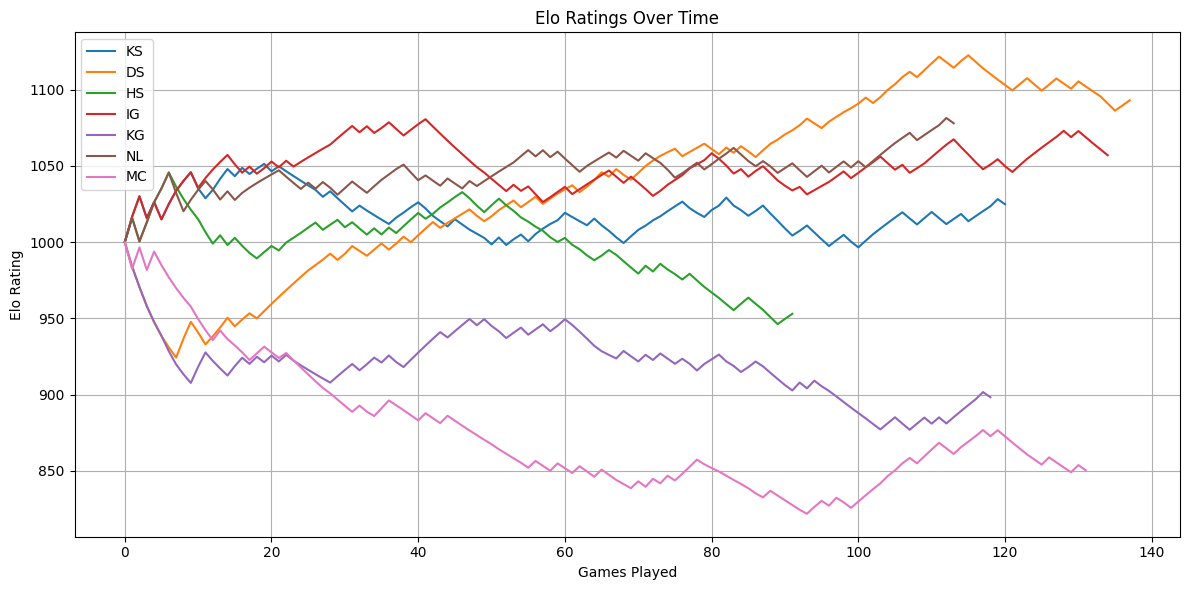

In [10]:
plt.figure(figsize=(12, 6))
for player in players:
    plt.plot(elo_history[player], label=player)

plt.title("Elo Ratings Over Time")
plt.xlabel("Games Played")
plt.ylabel("Elo Rating")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

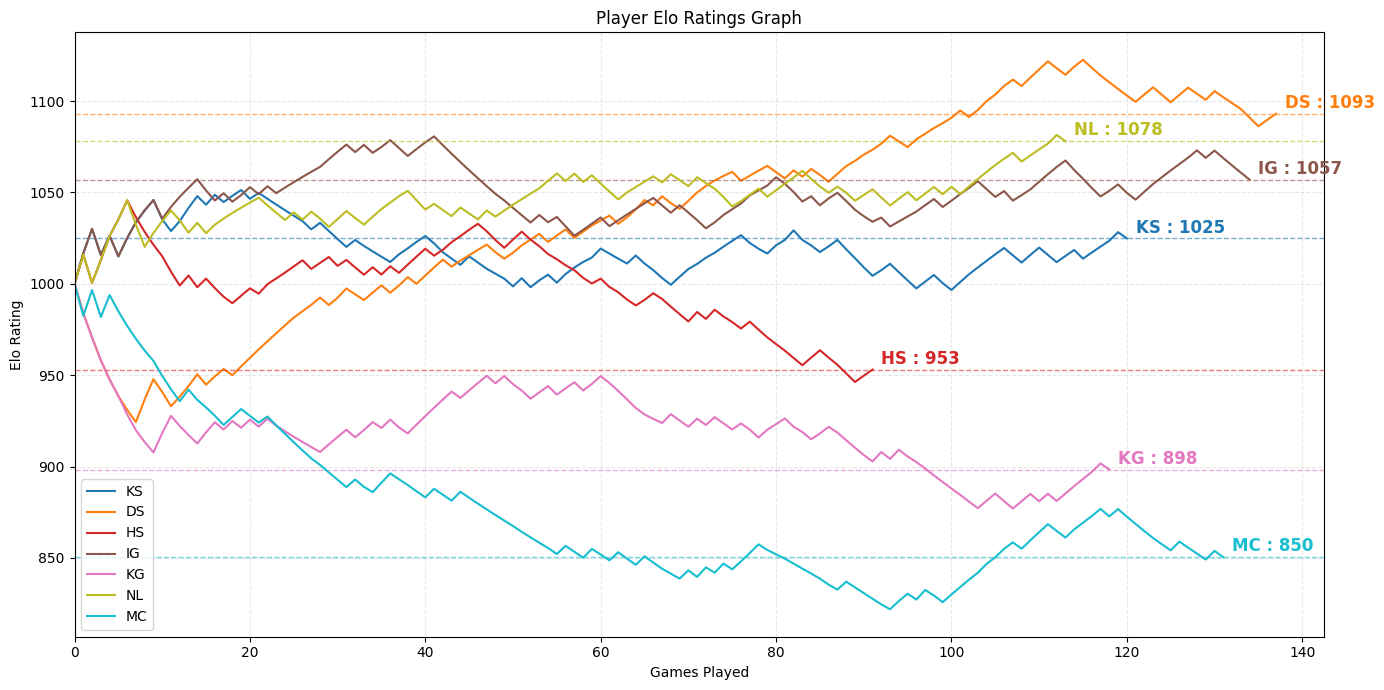

In [11]:
colors = plt.get_cmap('tab10', len(players))
plt.figure(figsize=(14, 7))

max_games = max(len(elo_history[player]) for player in players)
text_x = max_games + 2

for idx, player in enumerate(players):
    elos = elo_history[player]
    plt.plot(range(len(elos)), elos, label=player, color=colors(idx))
    final_elo = elos[-1]
    plt.axhline(y=final_elo, linestyle='--', color=colors(idx), linewidth=1, alpha=0.6)
    plt.text(len(elos), final_elo + 1, f"{player} : {final_elo:.0f}", color=colors(idx), fontsize=12, va='bottom', fontweight='bold')

plt.xlabel("Games Played")
plt.ylabel("Elo Rating")
plt.title("Player Elo Ratings Graph")
plt.xlim(0, text_x + 2.5)
plt.legend()
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig("C:/Projects/TT ELO/assets/elo_graph.png", dpi=300)
plt.show()
